**原始论文：** Trending Fast and Slow 

**论文解读：** [[量化]基于决策树模型的自适应时序动量策略](https://mp.weixin.qq.com/s?__biz=MzkxOTQzNDEzOA==&mid=2247484363&idx=1&sn=d814c8ec62bf217cec3dea657aec3bf4&chksm=c1a3653ef6d4ec283c2e987550761e651055c656cb48c33b7b639965a61efb3879ef3eaeb833&token=1991236374&lang=zh_CN#rd)

**论文简介:**  本文基于决策树开发了一种基于市场波动性的机器学习技术来结合长、短时间序列动量信号的方法,通过训练决策树模型来根据当前市场波动自适应的进行长，短时序动量策略的切换，相对原始的基准策略，可以大幅提高年化回报，并降低回撤。

**代码作者：** Spectator

**结构说明：**


1.   第一部分: 安装并导入依赖包;
2.   第二部分：加载数据;
3.   第三部分： 计算长短周期动量信号，作为策略信号进行回测;
4.   第四部分：训练决策树模型自适应的切换长短动量策略。



**结果说明：**

1. 论文中的月度波动率和训练算法都是复现的，可能和原文的设置并不完全一致，但是结果和原文结果是一致的。

2. 夏普，回撤等指标的计算并没有按照日频进行计算，所以和原文的结果存在较大出入，但是趋势是一致的。

# 第一部分: 安装并导入依赖包

**1. 安装依赖包**

In [ ]:
pip install yfinance && pip install pandas && pip install pandas && pip install quantstats && pip install scikit-learn

**2.导入依赖包**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import math
import yfinance
import pandas as pd
import numpy as np
import quantstats as qs
qs.extend_pandas()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree

# 第二部分：加载数据

**3.获得SP500历史数据**

In [ ]:
# 尝试使用yfinance API进行下载(需翻墙)
try:
    SP500_DATA=yfinance.download(tickers = "^GSPC", start="1900-01-07", interval="1d")
    SP500_DATA.to_csv("./SP500.csv")
# 使用提供的离线数据进行下载(无需翻墙)
except:
    SP500_DATA = pd.read_csv("./SP500.csv")
assert (SP500_DATA["Close"] == SP500_DATA["Adj Close"]).all()
SP500_DATA

**4. 计算日回报和月度波动率**

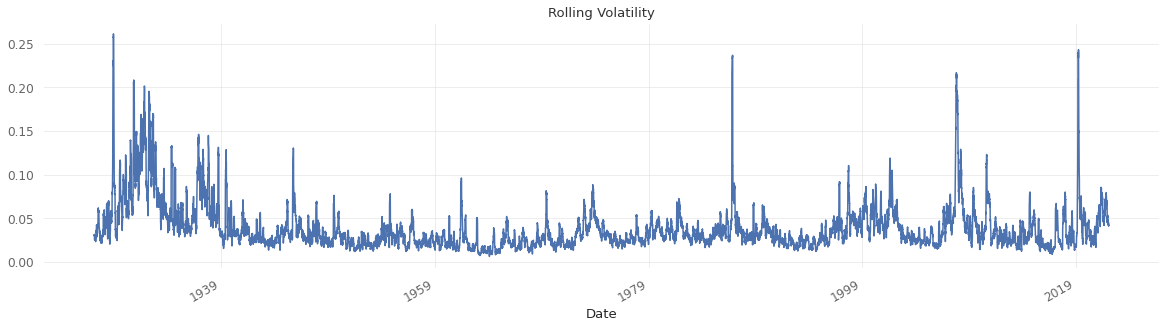

In [4]:
data = SP500_DATA
data["day_return"] = data.Close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
data["month_volatility"] = data.day_return.rolling(window=21).std()*math.sqrt(math.sqrt(252))
fig = data["month_volatility"].plot(title="Rolling Volatility", figsize=(20,5))

**5.查看历史收盘价曲线**

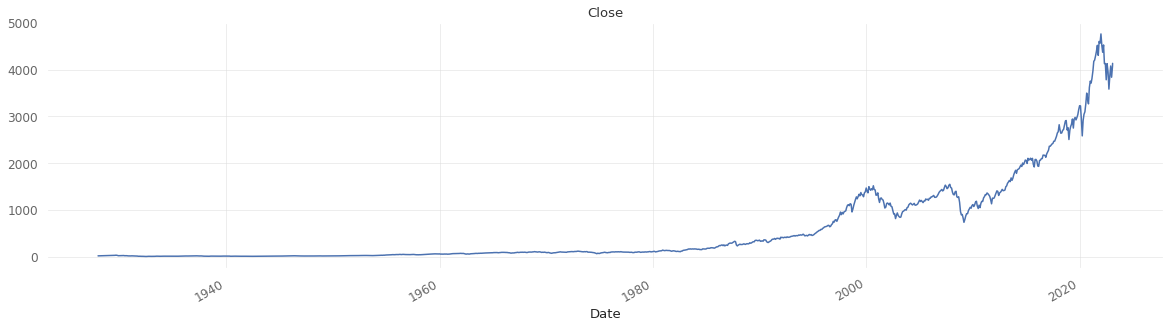

In [5]:
fig = data.loc[data.groupby(data.index.to_period('M')).apply(lambda x: x.index.max())].Close.plot(title="Close", figsize=(20,5))

**6. 获得月频数据**

In [ ]:
month_data = data.loc[data.groupby(data.index.to_period('M')).apply(lambda x: x.index.max())]
month_data

# 第三部分： 计算长短周期动量信号，作为策略信号进行回测

**7. 可视化长，短周期动量信号**

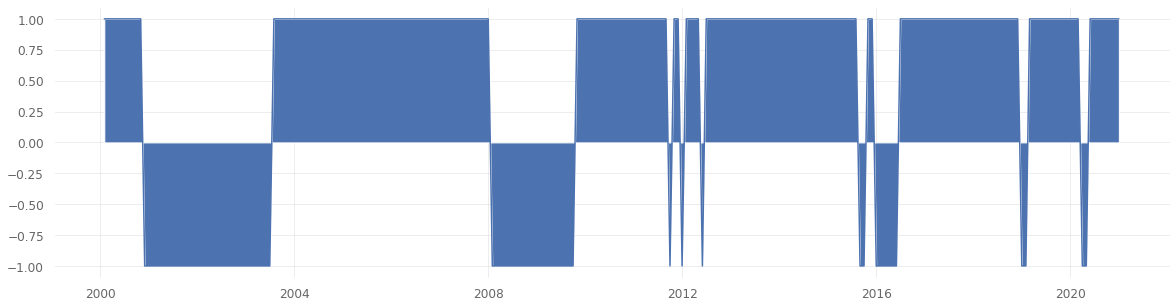

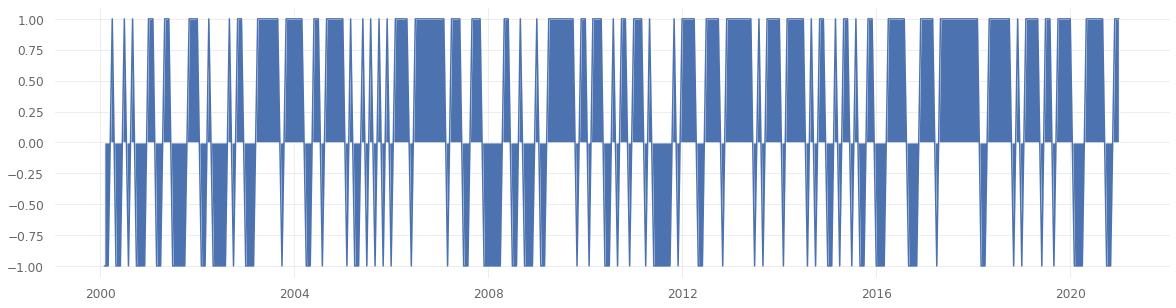

In [7]:
slow_return = month_data.Close.rolling(13).apply(lambda x:(x[-1]-x[0])/x[0])
slow_momentum_signal = (slow_return>0).astype(int)*2 -1
month_data["slow_momentum_signal"] = slow_momentum_signal

_slow_momentum_signal = slow_momentum_signal.loc['2000-01-01':'2020-12-31']
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(_slow_momentum_signal.index,_slow_momentum_signal.values)
_ = plt.fill_between(_slow_momentum_signal.index, 0, _slow_momentum_signal.values)

fast_return = month_data.Close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
fast_momentum_signal = (fast_return>0).astype(int)*2 - 1
month_data["fast_momentum_signal"] = fast_momentum_signal

_fast_momentum_signal = fast_momentum_signal.loc['2000-01-01':'2020-12-31']
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(_fast_momentum_signal.index,_fast_momentum_signal.values)
_ = plt.fill_between(_fast_momentum_signal.index, 0, _fast_momentum_signal.values)

**8.可视化短周期动量信号,长周期动量信号和市场的累积收益, 计算策略指标**

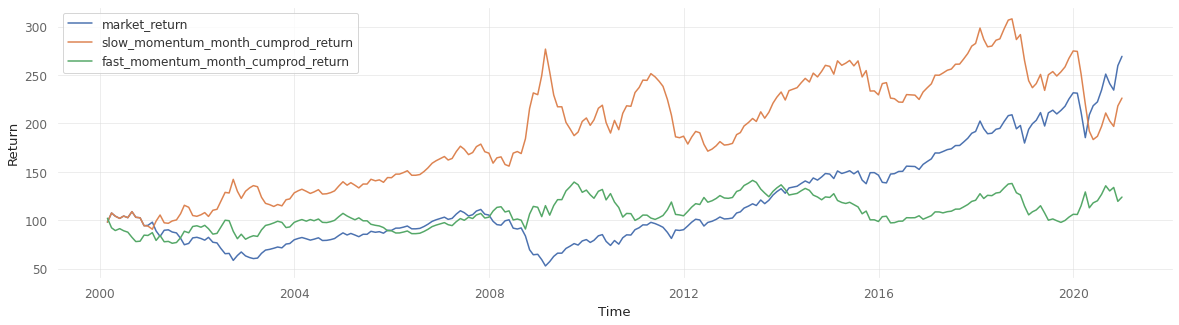

In [14]:
month_data["fast_momentum_flag"] = None
month_data["fast_momentum_flag"].iloc[1:] = month_data["fast_momentum_signal"].iloc[:-1]

month_data["slow_momentum_flag"] = None
month_data["slow_momentum_flag"].iloc[1:] = month_data["slow_momentum_signal"].iloc[:-1]

month_data["month_return"] = month_data.Close.rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
month_data["slow_momentum_month_return"] = month_data.slow_momentum_flag * month_data.month_return
month_data["fast_momentum_month_return"] = month_data.fast_momentum_flag * month_data.month_return


month_data_2000_2020 = month_data.loc['2000-02-01':'2020-12-31']

month_data_2000_2020["market_return"] = np.cumprod(month_data_2000_2020.month_return.values + 1) *100
month_data_2000_2020["slow_momentum_month_cumprod_return"] = np.cumprod(month_data_2000_2020["slow_momentum_month_return"].values + 1) * 100
month_data_2000_2020["fast_momentum_month_cumprod_return"] = np.cumprod(month_data_2000_2020["fast_momentum_month_return"].values + 1) * 100


_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('Return')
_ = plt.plot(month_data_2000_2020["market_return"].index,month_data_2000_2020["market_return"].values)
_ = plt.plot(month_data_2000_2020["slow_momentum_month_cumprod_return"].index,month_data_2000_2020["slow_momentum_month_cumprod_return"].values)
_ = plt.plot(month_data_2000_2020["fast_momentum_month_cumprod_return"].index,month_data_2000_2020["fast_momentum_month_cumprod_return"].values)
_ = plt.legend(['market_return', 'slow_momentum_month_cumprod_return', 'fast_momentum_month_cumprod_return']) 

result = {}
for i in ["slow_momentum_month_cumprod_return", "fast_momentum_month_cumprod_return", "market_return"]:
    result[i] = []
    for j in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
        exec( f"r = qs.stats.{j}(month_data_2000_2020[i])")
        result[i].append(r)

result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])
#result


# 第四部分：训练决策树模型自适应的切换长短动量策略

**9.标注训练数据,如果下一段时间长周期信号获得更高收益,则标记为0,否则为1**

In [ ]:
month_data["momentum_label"] = 0
month_data["momentum_label"][month_data["fast_momentum_month_return"] >= month_data["slow_momentum_month_return"]] = 1
# month_volatility下移一个时间单位，作为下一时间单位的输入
month_data["month_volatility"].iloc[1:] = month_data["month_volatility"].iloc[:-1]

month_data

**10.生成训练数据，使用决策树训练分类模型，训练目标为在当前市场波动情况下，在长周期和短周期动量信号的不一致的情况下，在下一个阶段采用的策略。**

In [10]:
tree_data = month_data[month_data.fast_momentum_flag != month_data.slow_momentum_signal]
X_train = tree_data.loc['1971-01-01':'2005-12-31']["month_volatility"].values.reshape(-1,1)
y_train = tree_data.loc['1971-01-01':'2005-12-31']["momentum_label"]

X_test = month_data.loc['2006-01-01':'2020-12-31']["month_volatility"].values.reshape(-1,1)
y_test = month_data.loc['2006-01-01':'2020-12-31']["momentum_label"]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test) 

**11.可视化对比预测值和真值**

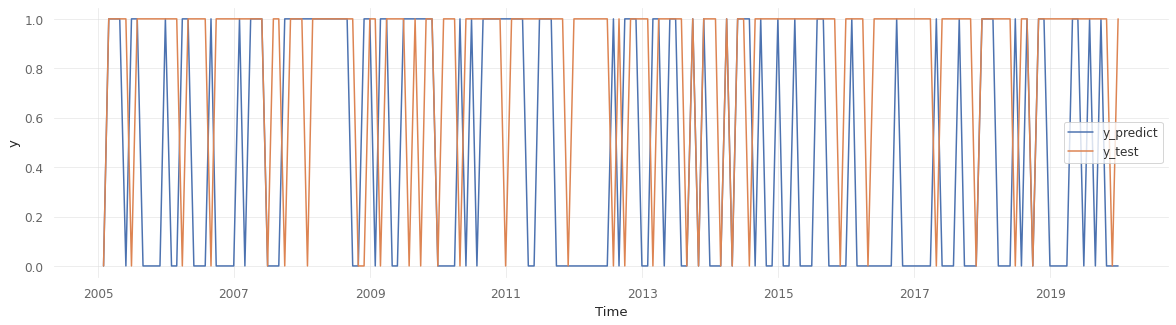

In [11]:
_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('y')
_ = plt.plot(y_test.index,y_predict)
_ = plt.plot(y_test.index,y_test)
_ = plt.legend(['y_predict', 'y_test']) 

**11.可视化短周期动量信号,长周期动量信号和树模型策略的累积收益**

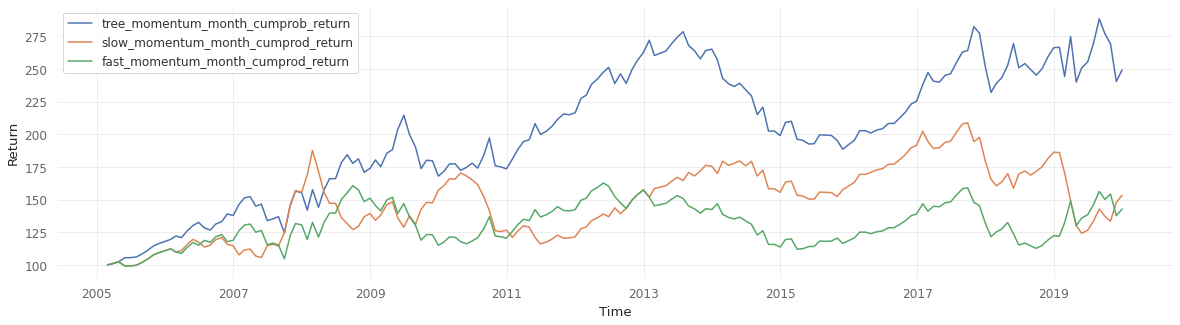

In [15]:
month_data["momentum_predict_label"] = None
month_data["momentum_predict_label"].loc['2006-01-01':'2020-12-31']= y_predict * 2 -1

month_data["tree_momentum_flag"] = month_data.fast_momentum_flag
month_data.tree_momentum_flag[(month_data.fast_momentum_signal * month_data.slow_momentum_signal + month_data.momentum_predict_label) == -2] *= -1
month_data["tree_momentum_month_return"] = month_data.tree_momentum_flag * month_data.month_return


month_data_2006_2020 = month_data.loc['2006-02-01':'2020-12-31']
month_data_2006_2020["tree_momentum_month_cumprob_return"] = np.cumprod(month_data_2006_2020["tree_momentum_month_return"].values + 1) *100
month_data_2006_2020["slow_momentum_month_cumprod_return"] = np.cumprod(month_data_2006_2020["slow_momentum_month_return"].values + 1) * 100
month_data_2006_2020["fast_momentum_month_cumprod_return"] = np.cumprod(month_data_2006_2020["fast_momentum_month_return"].values + 1) * 100

_ = plt.figure(figsize=(20, 5))
plt.xlabel('Time') 
plt.ylabel('Return')
_ = plt.plot(month_data_2006_2020["tree_momentum_month_cumprob_return"].index,month_data_2006_2020["tree_momentum_month_cumprob_return"].values)
_ = plt.plot(month_data_2006_2020["slow_momentum_month_cumprod_return"].index,month_data_2006_2020["slow_momentum_month_cumprod_return"].values)
_ = plt.plot(month_data_2006_2020["fast_momentum_month_cumprod_return"].index,month_data_2006_2020["fast_momentum_month_cumprod_return"].values)
_ = plt.legend(['tree_momentum_month_cumprob_return', 'slow_momentum_month_cumprod_return', 'fast_momentum_month_cumprod_return']) 


result = {}
for i in ["slow_momentum_month_cumprod_return", "fast_momentum_month_cumprod_return", "tree_momentum_month_cumprob_return"]:
    result[i] = []
    for j in ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]:
        exec( f"r = qs.stats.{j}(month_data_2006_2020[i])")
        result[i].append(r)

result = pd.DataFrame(result, index=["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"])
#result
